In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from IPython.display import Image, display, Markdown
from PIL import Image as PILImage
from scipy import stats
from tqdm import tqdm
from helpers import *

# initialize tqdm for pandas
tqdm.pandas()
# turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None
# turn off warnings
import warnings
warnings.filterwarnings('ignore')

# define path
DIR = ".\\data\\raw"
PATH_DF_CHANNELS = DIR + '\\df_channels_en.tsv.gz'
PATH_DF_TIMESERIES = DIR + '\\df_timeseries_en.tsv.gz'
PATH_YT_METADATA = DIR + '\\yt_metadata_en.jsonl.gz'
PATH_NUM_COMMENTS = DIR  + '\\num_comments.tsv.gz'

In [2]:
#define colorblind friendly palette to be used in our plots
colors = sns.color_palette("colorblind",5)

## Analysis of videos of less than 20 minutes

In [31]:
df_tech_review_mt = pd.read_csv('yt_tech_channels_metadata.tsv.gz', sep="\t", compression="infer")
df_tech_review_mt = df_tech_review_mt.drop('Unnamed: 0',axis=1)
df_vd_tech = df_tech_review_mt[df_tech_review_mt.tech_review]

### Video duration

Let's start off with the analysis of a video duration. We can take the number of likes and dislikes as metrics of a video. We first want to know if there is any correlation between likes/dislikes and the duration of a video. Below, we are calculating the pearson correlation between the number of likes/dislikes and the duration of a video. We decided to take the pearson correlation, as the correlation is linear (to be seen later)

In [32]:
def get_correlations(df_vd_tech):
    '''
    df_vd_tech: dataframe to use for computing the correlations
    
    returns: pearson correlation between duration and # of likes as well as duration and # of dislikes
    '''
    # filter only the tech review videos by tech review channels
    df_vd_tech["upload_date"] = pd.to_datetime(df_vd_tech["upload_date"])
    df_vd_tech["upload_year"] = df_vd_tech['upload_date'].dt.year

    # correlation between the duration of the video and number of likes and dislikes
    df_vd_tech_filtered = df_vd_tech.copy()
    # just to avoid division by 0
    df_vd_tech_filtered["view_count"] = df_vd_tech_filtered["view_count"].replace({0:1})
    #correlation between like count and duration
    df_vd_tech_filtered["like_count_ratio"] = df_vd_tech_filtered['like_count']/df_vd_tech_filtered["view_count"]
    df_vd_tech_filtered["dislike_count_ratio"] = df_vd_tech_filtered['dislike_count']/df_vd_tech_filtered["view_count"]
    pearson_like_duration_corrs = []
    pearson_dislike_duration_corrs = []

    years = np.unique(df_vd_tech_filtered["upload_year"])
    for year in years:
        #compute pearson correlation
        df = df_vd_tech_filtered[df_vd_tech_filtered["upload_year"]==year].dropna()
        corr_like = stats.pearsonr(df["duration"], df['like_count_ratio'])
        corr_dislike = stats.pearsonr(df["duration"], df['dislike_count_ratio'])
        pearson_like_duration_corrs.append(corr_like)
        pearson_dislike_duration_corrs.append(corr_dislike)

    df_corrs_pearson_like = pd.DataFrame(pearson_like_duration_corrs, columns=["pearson_corr", "p_value"], index=years)
    df_corrs_pearson_dislike = pd.DataFrame(pearson_dislike_duration_corrs, columns=["pearson_corr", "p_value"], index=years) 
    
    return df_corrs_pearson_like, df_corrs_pearson_dislike

In [33]:
df_corrs_pearson_like, df_corrs_pearson_dislike = get_correlations(df_vd_tech)

In [34]:
def plot_correlations(df_corrs_pearson_like, df_corrs_pearson_dislike):
    '''
    df_corrs_pearson_like: dataframe containing pearson correltions with their p-values between likes and duration per year
    df_corrs_pearson_dislike: dataframe containing pearson correltions with their p-values between dislikes and duration per year

    plots the pearson correlations as a bar plot
    '''
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Create a bar plot for Pearson correlation coefficients
    bar_like = axs[0].bar(df_corrs_pearson_like.index, df_corrs_pearson_like["pearson_corr"], color=colors[0], alpha=0.7)
    bar_dislike = axs[1].bar(df_corrs_pearson_dislike.index, df_corrs_pearson_dislike["pearson_corr"], color=colors[0], alpha=0.7)

    # Highlight bars where p-values are less than 0.05
    for bar, p_value in zip(bar_like, df_corrs_pearson_like["p_value"]):
        if p_value < 0.05:
            bar.set_color(colors[1])
    for bar, p_value in zip(bar_dislike, df_corrs_pearson_dislike["p_value"]):
        if p_value < 0.05:
            bar.set_color(colors[1])

    # Set labels and title
    axs[0].set_title('# Likes vs Duration')
    axs[1].set_title('# Dislikes vs Duration')

    # Display a legend indicating significance
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='p < 0.05')],
               loc='upper right')
    plt.suptitle('Pearson Correlation Coefficients per Year')
    plt.tight_layout()
    plt.show()

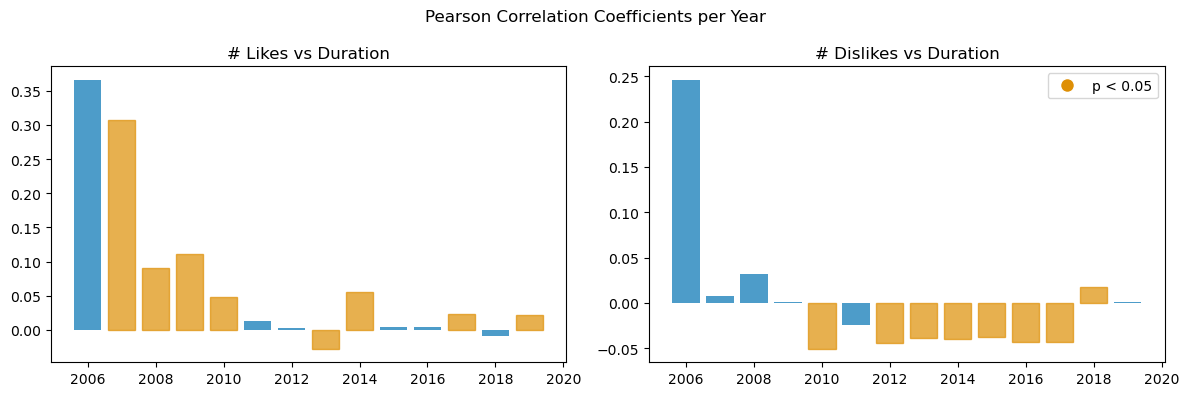

In [35]:
plot_correlations(df_corrs_pearson_like, df_corrs_pearson_dislike)

There is a relatively high positive correaltion (that is decreasing across the years), but significant (p_value < 0.05) between the duration of a video and the number of likes it gets. This is different from causation (i.e this does NOT mean that by uploading a longer video we will get more likes) but this nonetheless means that with longer videos we tend to have a bigger number of likes. Moreover, we see that with longer videos the number of dislikes decreases (significant negative correlation in most years between # of dislikes and duration) which further proves the point.

This can be explained by the fact that with longer videos on average, the video contains more content and so is more valuable/interesting and thus gets more likes. Note that here we are looking at videos of duration less than 20 minutes which means less number of ads in the video and a less lengthy/boring video. We will later look at videos of more than 20 minutes to see whether this changes or not.

Let's see how do top and worst channels (in terms of like-dislike ratio) relate to this.

In [36]:
def compute_ratios_and_print_duration(df_vd_tech):
    '''
    computes the like to dislike ratio and prints the duration
    
    df_vd_tech: dataframe to use for the statistics computation
    
    retuns the dataframe containing the ratio
    '''
    
    # get the likes to dislikes ratio
    df_vd_tech_ratio = df_vd_tech[['channel_id', 'upload_year','like_count','dislike_count','display_id','duration']]
    df_vd_tech_ratio['dislike_count'] = df_vd_tech_ratio['dislike_count'].replace({0:1})
    df_vd_tech_ratio['dislike_count'].fillna(1,inplace=True)
    df_vd_tech_ratio['like_dislike_ratio'] = df_vd_tech_ratio['like_count'] / df_vd_tech_ratio['dislike_count']
    df_vd_tech_ratio.like_dislike_ratio.fillna(0,inplace=True)

    #group videos per channel and compute the average duration and like to dislike ratio (per channel). 
    #Sort by the latter and get the top 100 and bottom 100 like to dislike ratios and compute the average of 
    #their duration averages (macro average). Note that by computing average per channel we give every channel the same weight.
    df_vd_tech_sorted = df_vd_tech_ratio.groupby("channel_id")[["duration", "like_dislike_ratio"]].mean().sort_values(by='like_dislike_ratio', ascending=False)
    print("The average duration of a video from the top 10% of channels (in terms of like to dislike ratio) is {:.0f} seconds and the average duration of a video from the bottom 10% of channels is {:.0f}.".format(\
    df_vd_tech_ratio.iloc[0:(int)(0.1*len(df_vd_tech_ratio))].duration.mean(), df_vd_tech_ratio.iloc[(int)(0.9*len(df_vd_tech_ratio)):].duration.mean()))
    print(stats.ttest_ind(df_vd_tech_ratio.iloc[0:(int)(0.1*len(df_vd_tech_ratio))].duration, df_vd_tech_ratio.iloc[(int)(0.9*len(df_vd_tech_ratio)):].duration))

    return df_vd_tech_ratio

In [37]:
df_vd_tech_ratio = compute_ratios_and_print_duration(df_vd_tech)

The average duration of a video from the top 10% of channels (in terms of like to dislike ratio) is 375 seconds and the average duration of a video from the bottom 10% of channels is 351.
TtestResult(statistic=8.441690694848564, pvalue=3.273991080221707e-17, df=28521.0)


We see that the "top" channels (the ones that have a higher like to dislike ratio on their videos) have longer videos on average (375 seconds compared to 351 seconds) and this difference is statistically significant (p-value < 0.05).

Let's now see the trend of likes, dislikes, and duration to take their evolution into consideration. 

In [38]:
def plot_helper(df_vd_tech):
    '''
    helper function to plot various statistics
    
    df_vd_tech: dataframe to use for the statistics computation
    '''
    # just to avoid division by 0
    df_vd_tech['dislike_count'] = df_vd_tech['dislike_count'].replace({0:1})

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True)

    sns.pointplot(x=df_vd_tech['upload_year'],
                  y=df_vd_tech['like_count'],
                  errwidth=1.5,
                  color=colors[0],
                  ax=axs[0][0])

    sns.pointplot(x=df_vd_tech['upload_year'],
                  y=df_vd_tech['dislike_count'],
                  errwidth=1.5,
                  color=colors[0],
                  ax=axs[0][1])
    
    sns.pointplot(x=df_vd_tech['upload_year'],
                  y=df_vd_tech['like_count'] / df_vd_tech['dislike_count'],
                  errwidth=1.5,
                  color=colors[0],
                  ax=axs[1][0])

    sns.pointplot(x=df_vd_tech['upload_year'],
                  y=df_vd_tech['duration'],
                  errwidth=1.5,
                  color=colors[0],
                  ax=axs[1][1])

    axs[0][0].set(title='Average number of likes per year', xlabel=None)
    axs[0][0].grid(axis='y', linestyle='--')
    axs[0][0].tick_params(axis='x', rotation=45)
    axs[0][0].set_xlabel('years')
    
    axs[0][1].set(title='Average number of dislikes per year', xlabel=None)
    axs[0][1].grid(axis='y', linestyle='--')
    axs[0][1].tick_params(axis='x', rotation=45)
    axs[0][1].set_xlabel('years')
    
    axs[1][0].set(title='Average ratio of like to dislike per video per year', xlabel=None)
    axs[1][0].grid(axis='y', linestyle='--')
    axs[1][0].tick_params(axis='x', rotation=45)
    axs[1][0].set_xlabel('years')
    axs[1][0].set_ylabel("like-dislike ratio")
    
    axs[1][1].set(title='Average video duration per year', xlabel=None)
    axs[1][1].grid(axis='y', linestyle='--')
    axs[1][1].tick_params(axis='x', rotation=45)
    axs[1][1].set_xlabel('years')

    plt.tight_layout()
    plt.show()

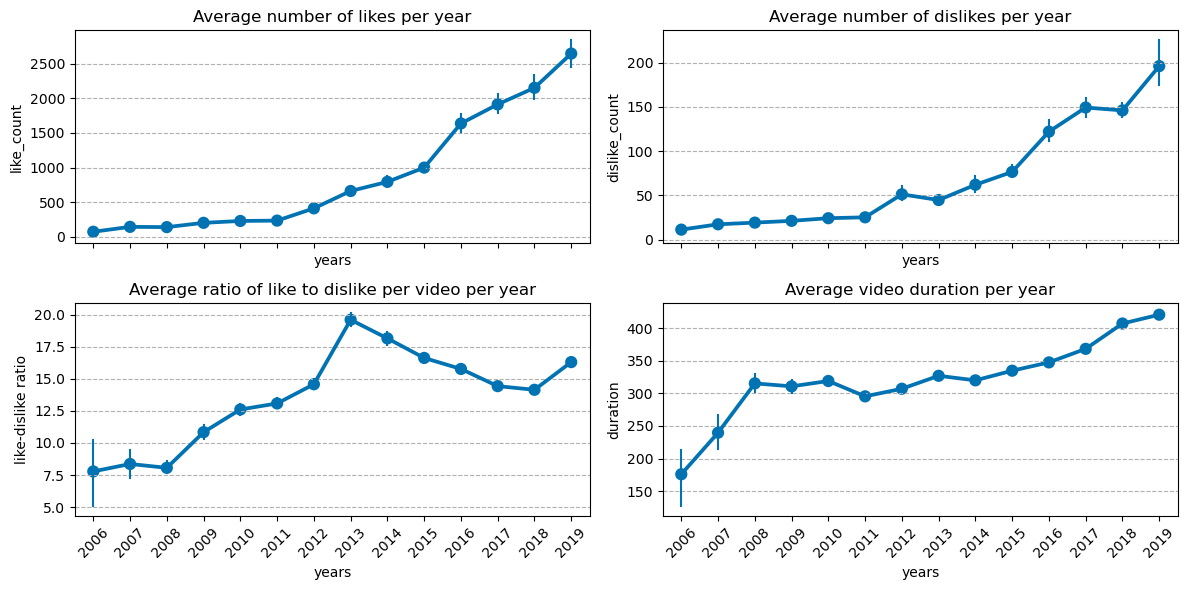

In [39]:
plot_helper(df_vd_tech)

We see from the above plot that both number of dislikes and likes have been increasing across the years. Multiple reasons can justify this: for instance this could be due to more users on the platform (over the years YouTube has become a popular platform, attracting more users, and therefore likes and dislikes as well) or more user engagement (users engage with the content and give their opinion which can be positive or negative, instead of saying nothing).

We can also see that the length of youtube videos has been increasing over the years: it went from less than 200 seconds (3.3 minutes) in 2006 to more than 400 seconds (6.6 minutes) in 2019 on average. This can be explained by the various technological advancements (bigger memory space to store and upload the videos, better camera battery, camera portability, etc), and to the higher creativity youtubers have to film longer videos that include more content.

Particularly, the increase in the ratio of number of likes compared to dislikes can explain the correlations we had in the previous plots. Namely, why we had higher correaltion between Likes and Duration, and less correlation between Dislikes and Duration.

Let's now see how the video duration is related to user engagement. We do it by plotting the moving average of likes to dislikes ratio over the duration of a video.

In [40]:
def plot_moving_avg(df_vd_tech_ratio, window, short):
    '''
    df_vd_tech_ratio: dataframe to be used to compute the moving avg
    window: window of the moving average
    short: either 0 or 1 for either long or short videos respectively
    '''
    ## sort videos by duration
    df_vd_tech_ratio.sort_values(by='duration',inplace=True)

    # plot moving average of likes to dislikes ratio versus duration
    plt.figure(figsize=(6,3))
    y = df_vd_tech_ratio["like_dislike_ratio"].rolling(window).mean().values
    x = df_vd_tech_ratio['duration']
    #if short videos only plot from 0 to 20 minutes else from 20 minutes to the longest duration
    if(short):
        plt.xlim(0,max(df_vd_tech_ratio['duration']))
    else:
        plt.xlim(1200, max(df_vd_tech_ratio['duration']))
        plt.xscale('log')
        plt.xticks([1200, 10000, 100000])
    ax = sns.lineplot(x=x, y=y, color=colors[0])
    ax.set(title='Moving average of likes-to-dislikes ratio over the duration of video', xlabel='Duration (seconds)', ylabel='#likes / #dislikes')
    plt.show()

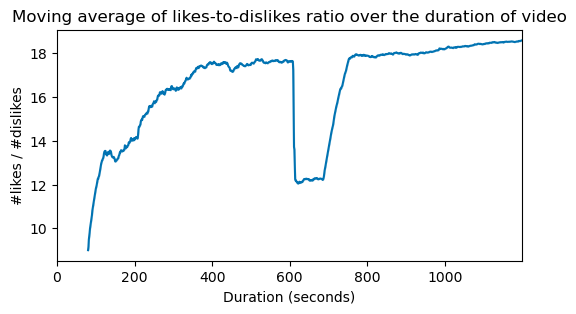

In [13]:
plot_moving_avg(df_vd_tech_ratio, 10000, 1)

We can see from this plot that generally the longer videos (for videos up to 20min) tend to be liked more by the users, except for the videos between 10 - 11 minutes. This could be because of an enormous number of videos on YouTube with this duration, which might include a lot of low quality videos as well, as youtubers usually try to produce videos around 10 minutes to benefit from more ads on their videos (Youtube has a video length threshold of 10 min past which youtubers get 2 ads on their videos and thus more money). We analyse this drop further.

In [41]:
def plot_statistics_across_duration_intervals(df_vd_tech_ratio, threshold):
    '''
    df_vd_tech_ratio: dataframe to use to compute the statistics
    threshold: int taking 2 possible values: if 2004 take all videos and if 2010 take videos from 2011 to 2019
    '''
    df_vd_tech_ratio['duration_intervals'] = pd.cut(df_vd_tech_ratio['duration'], bins=10)

    fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15, 11))
    fig.tight_layout()
    fig.suptitle("mean of like_dislike_ratio, like_count, dislike_count and # of videos for each duration interval for videos uploaded after 2010", y=1)

    number_of_videos_per_interval = df_vd_tech_ratio[df_vd_tech_ratio['upload_year']>threshold].groupby('duration_intervals', as_index=False).apply(lambda x: len(x)).rename(columns={None: 'number_of_videos'})
    #plot the like and dislike count on the same log scale to first spread the data better and to have easier/better visual comparison of the two counts
    axs[1].set_yticks(([100, 1000, 10000]))
    axs[1].set_yscale('log')
    axs[2].set_yticks(([100, 1000, 10000]))
    axs[2].set_yscale('log')
    sns.barplot(x='duration_intervals', y='like_dislike_ratio', data=df_vd_tech_ratio[df_vd_tech_ratio['upload_year']>threshold], ax=axs[0], estimator ='mean', color=colors[0])
    sns.barplot(x='duration_intervals', y='like_count', data=df_vd_tech_ratio[df_vd_tech_ratio['upload_year']>threshold], ax=axs[1], color=colors[1])
    sns.barplot(x='duration_intervals', y='dislike_count', data=df_vd_tech_ratio[df_vd_tech_ratio['upload_year']>threshold], ax=axs[2], color=colors[2])
    sns.barplot(x='duration_intervals', y='number_of_videos', data=number_of_videos_per_interval, ax=axs[3], color=colors[4])

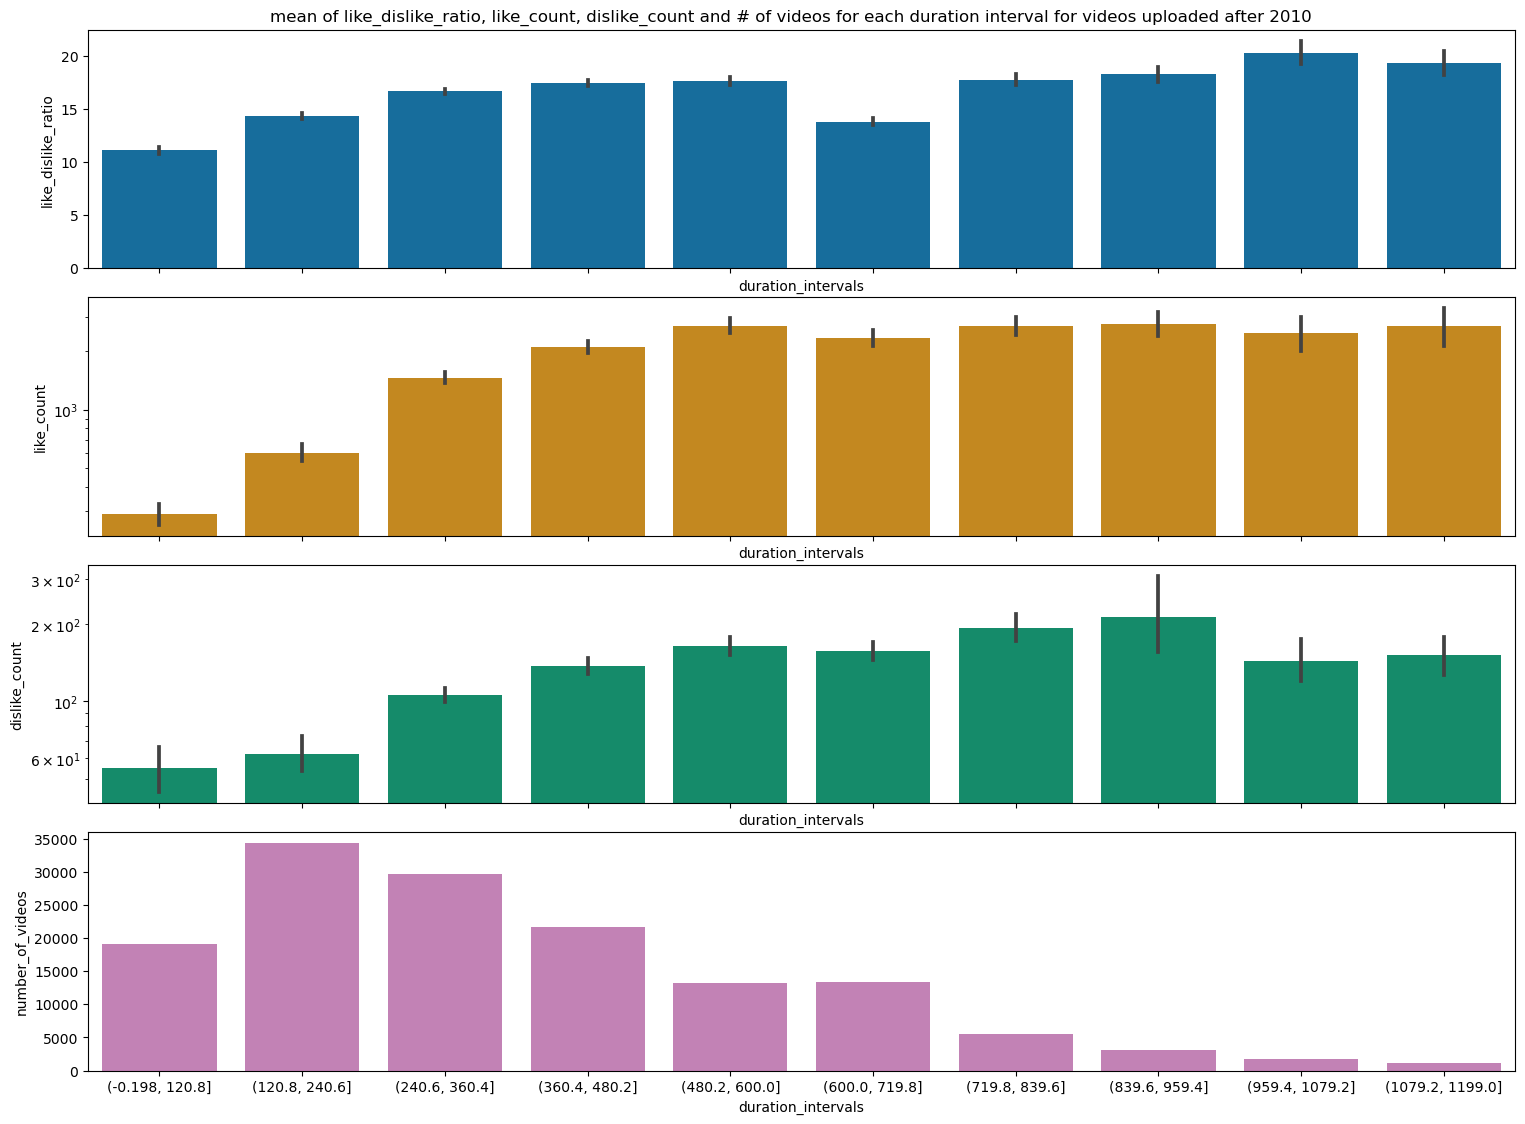

In [42]:
plot_statistics_across_duration_intervals(df_vd_tech_ratio, 2004)

We see that even by plotting the mean for each time interval (not 'moving') the drop is still there. Also, we notice that the number likes decreased but the number of dislikes and number of videos stayed the same between the 10 min interval and the interval before it.

[Text(0.5, 1.0, 'Distribution of like-dislike ratio for videos in the interval (600, 719.8]')]

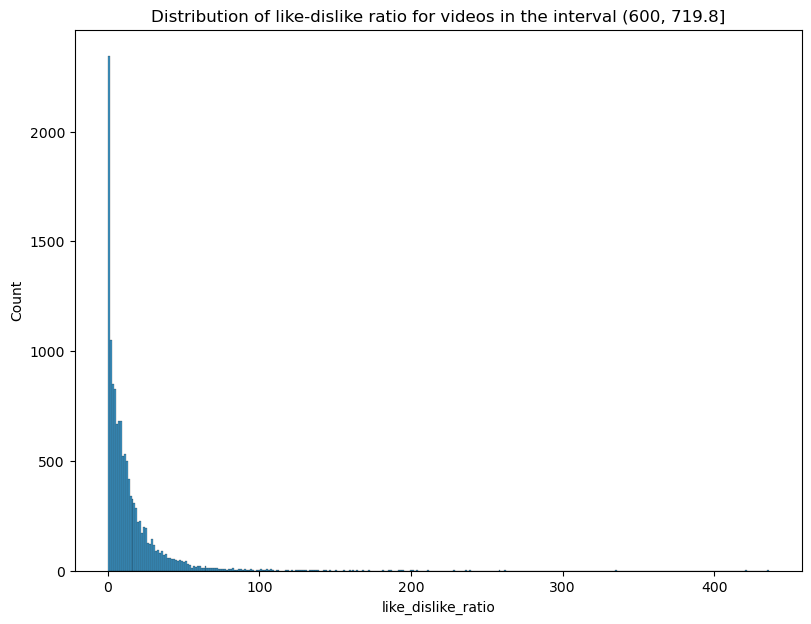

In [43]:
#plot the distribution of like-dislike ratio for the 10 min interval
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.tight_layout()
sns.histplot(data=df_vd_tech_ratio[df_vd_tech_ratio['duration_intervals'] == (pd.Interval(600, 719.8))], x='like_dislike_ratio', ax=ax, color=colors[0]).set(title='Distribution of like-dislike ratio for videos in the interval (600, 719.8]')

We see that, for the time interval 600 seconds to 719.8 = 10 minutes to 12 minutes) the distribution of likes to dislikes ratio follows a power law (most videos have a low like to dislike ratio while few have a really high like to dislike ratio). Therefore, it might not be optimal to plot the mean for the like to dislike ratio but instead the median. 

[Text(0.5, 1.0, 'median of like_dislike_ratio for each duration interval')]

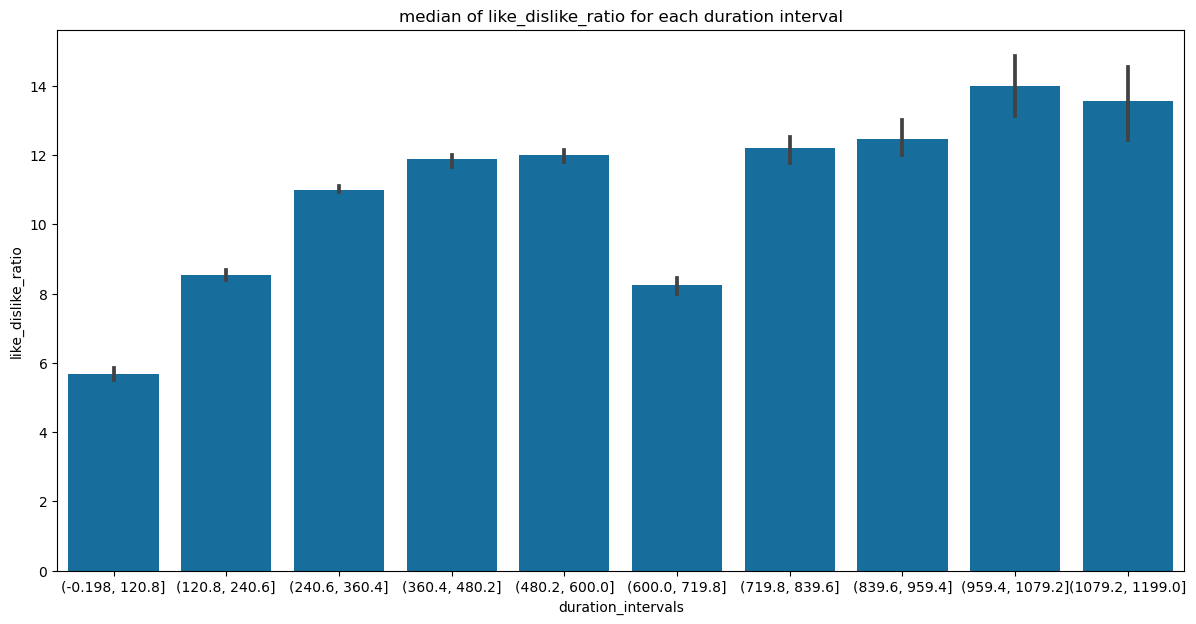

In [44]:
#plot the median of like-dislike ratio for each interval
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig.tight_layout()
sns.barplot(x='duration_intervals', y='like_dislike_ratio', data=df_vd_tech_ratio, estimator ='median', ax=ax, color=colors[0]).set(title='median of like_dislike_ratio for each duration interval')

Unfortunately, even with the median we see the same drop. This is can be justified by the fact that there are a lot of videos with low like to dislike ratio and so the median becomes really close to the minimum which is not insightful. What if we try to plot the sum of likes to dislikes ratios for each time interval? We do this next.

[Text(0.5, 1.0, 'sum of like_dislike_ratio for each duration interval')]

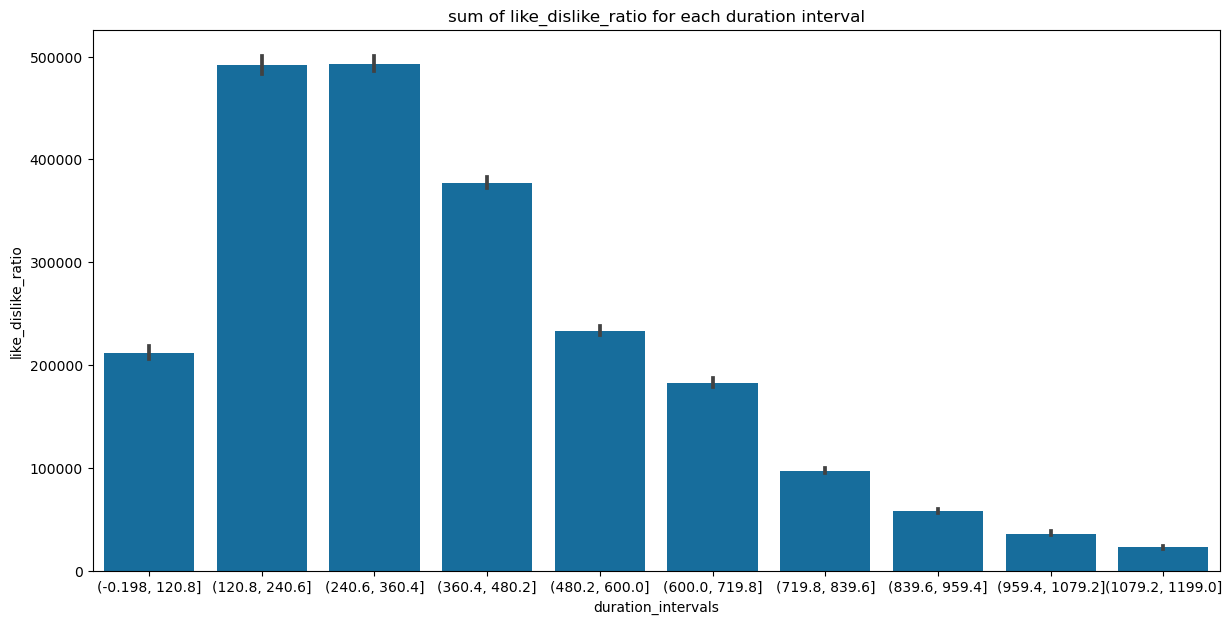

In [18]:
#plot the sum of like-dislike ratio for each interval
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig.tight_layout()
sns.barplot(x='duration_intervals', y='like_dislike_ratio', data=df_vd_tech_ratio, estimator ='sum', ax=ax, color=colors[0]).set(title='sum of like_dislike_ratio for each duration interval')

We see from the above plot that the sum is decreasing from small duration to high duration (from the left time interval to the right time interval), but the number of videos stayed the same for the 2 time intervals (480.2, 600] and (600, 719.8] which explains the drop seen when computing the mean (as we have the same denominator but a lower numerator: the like to dislike ratio is decreasing from small duration to high duration, whereas the number of videos has been decreasing from small duration to high duration **except** for the time interval of around 600 seconds = 10 minutes). 

But why is the number of videos the same for those 2 duration intervals? From 2006 to 2010, youtube introduced a ten-minute limit on the length of videos after noticing that the majority of videos exceeding this length were unauthorized uploads of television shows and films. This might bias our analysis as this could push the number of videos around 10 minutes up, because people can't upload a video of more than that duration and so they would be condensed around that video length, thus explaining why we have the same number of videos at around 10 minutes.

In [19]:
print("The total number of tech review videos from 2005 to 2019 is: ", len(df_vd_tech_ratio))

The total number of tech review videos from 2005 to 2019 is:  142615


In [20]:
print("The total number of tech review videos from 2010 to 2019 is: ", len(df_vd_tech_ratio[df_vd_tech_ratio['upload_year']>2010]))

The total number of tech review videos from 2010 to 2019 is:  137170


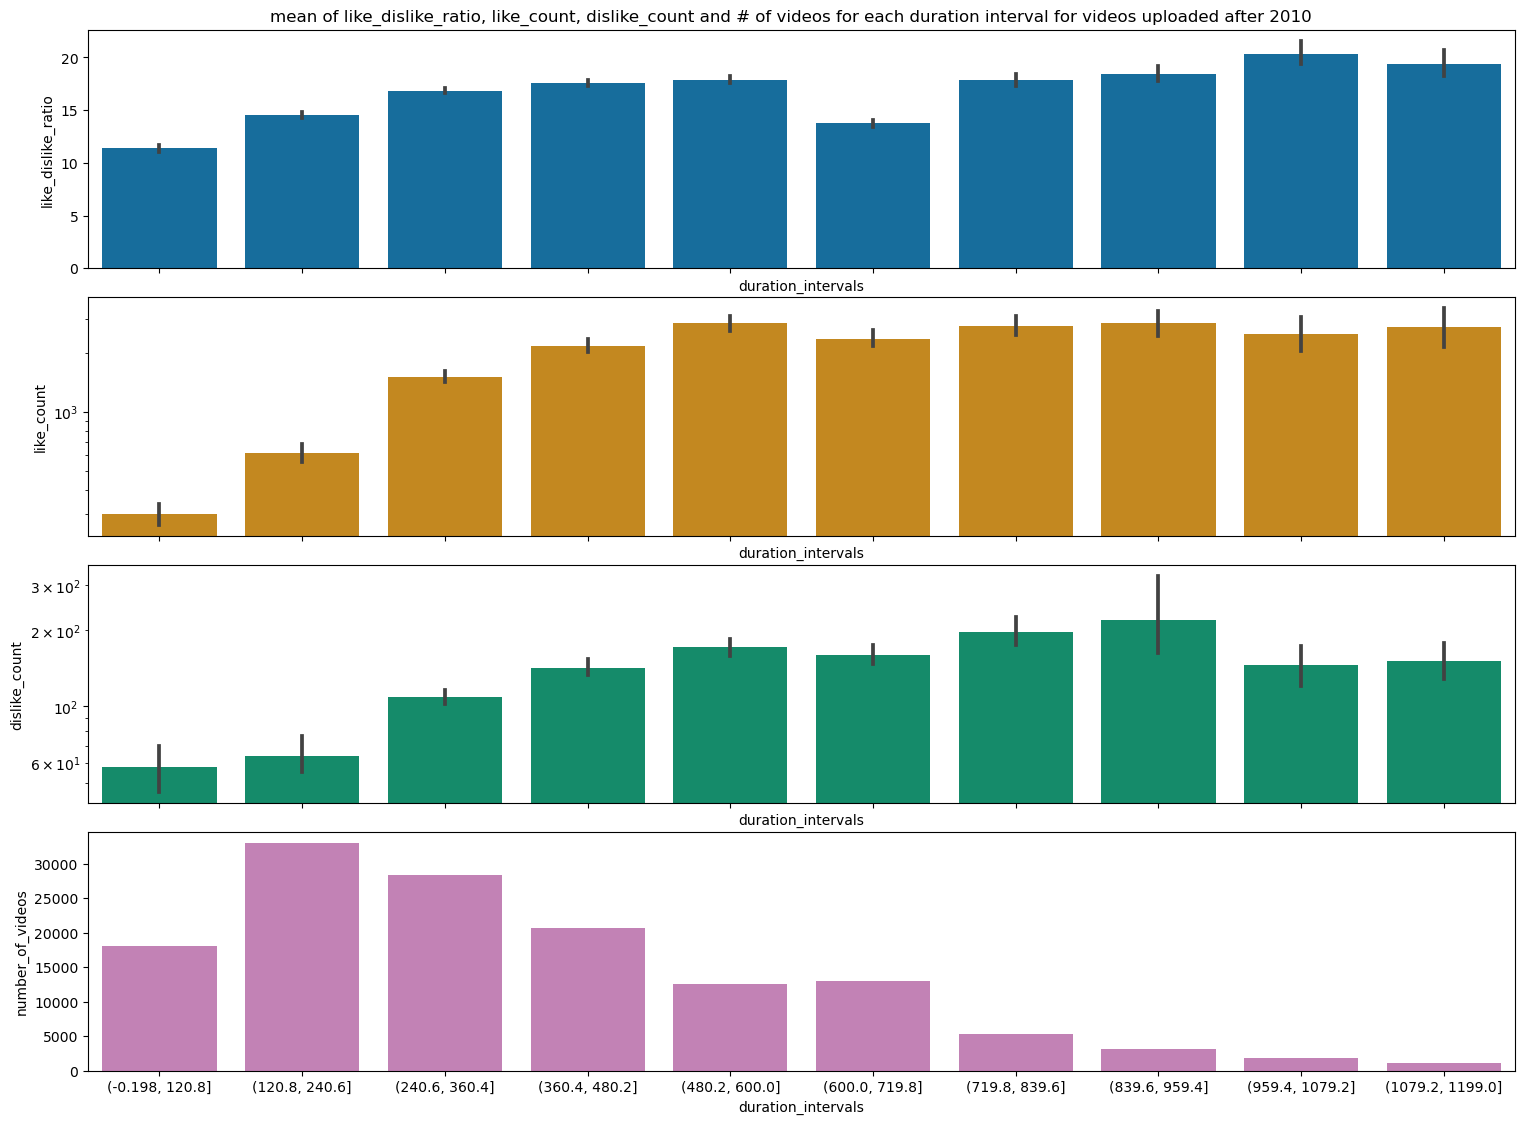

In [21]:
plot_statistics_across_duration_intervals(df_vd_tech_ratio, 2010)

By only keeping the videos uploaded starting from 2011, we see that the number of videos goes from 142000 to 137000  which is not signifciant to bias our study, and which makes sense as youtube wasn't that popular from 2006 to 2010 and not many people became youtubers. To be sure we plot the above 4 plots for this period (excluding videos uploaded before 2011). We see that the trends are the same and particularly the drop in like to dislike ratio around 10 min videos is still present. 
After this analysis, we can be confident that the fact that the number of videos stayed the same for these 2 intervals is explained by the fact that youtube allows for 2 ads for videos of length passed 10 minutes, which motivates youtubers to upload videos of this length. Moreover, the number of dislikes didn't decrease significantly but it's instead the number of likes that decreased remarkably. This combined with the constant number of videos for the intervals (480.2, 600.0] and (600.0, 719.8] explain why the moving median and mean had a drop at the 10 min duration.  

We also note that the best range for duration (the one with highest like-dislike ratio) is (959.4, 1199] ~ (16min, 20with a ratio of ~20. It's important to note that this isn't a hard rule, other ranges can also be successful, and as we have seen the 10 min range is actually not to be avoided because the drop we see is due to the high number of videos in that range and to the diverse nature/quality of the videos in it.

## Analysis of videos of more than 20 minutes

In [22]:
df_vd_tech = pd.read_csv('df_vd_tech.tsv.gz', sep="\t", compression="infer")

### Video duration

We apply the same analyis we did for videos of less than 20 minutes, that is we are calculating the pearson correlation between the number of likes/dislikes and the duration of a video.

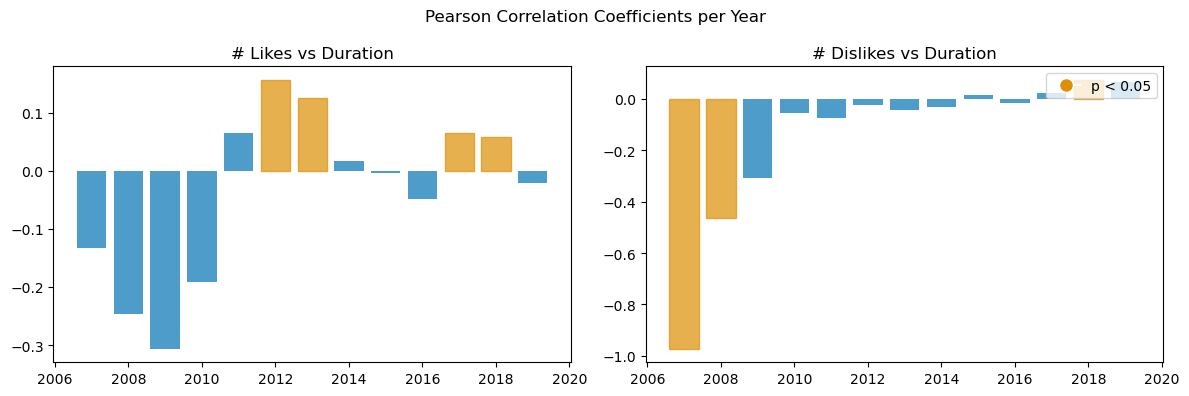

In [23]:
df_corrs_pearson_like, df_corrs_pearson_dislike = get_correlations(df_vd_tech)
plot_correlations(df_corrs_pearson_like, df_corrs_pearson_dislike)

We see that we no longer have that for most years, the longer the video the more likes it gets as we had for the videos of less than 20 minutes but we instead have more negative correlations appearing. This is expected as longer videos tend to be more boring. However, these negative correlations are not significant and this is because no one really watches really long videos. Furthermore, the negative correlations between the duration of a video and the number of dislikes it gets in more recent years are now less statistically significant (compared to videos of less than 20 min) and a positive correlation trend is emerging which makes sense as again usually the longer the video the more boring it is. The opposite effect is seen here compared to videos of less that 20 minutes.

Let's now see how do top and worst channels (in terms of like-dislike ratio) relate to this.

In [24]:
df_vd_tech_ratio = compute_ratios_and_print_duration(df_vd_tech)

The average duration of a video from the top 10% of channels (in terms of like to dislike ratio) is 2665 seconds and the average duration of a video from the bottom 10% of channels is 2729.
TtestResult(statistic=-0.46367349529775137, pvalue=0.6429467094425946, df=1552.0)


We see that the "top" channels (the ones that have a higher like to dislike ratio on their videos) now have shorter videos on average (2665 seconds compared to 2729 seconds) hinting that it's best to stay closer to the 20 minutes mark. However, the p-value now is larger than 0.05 and so the difference is not statistically significant. We need to further analyse this.

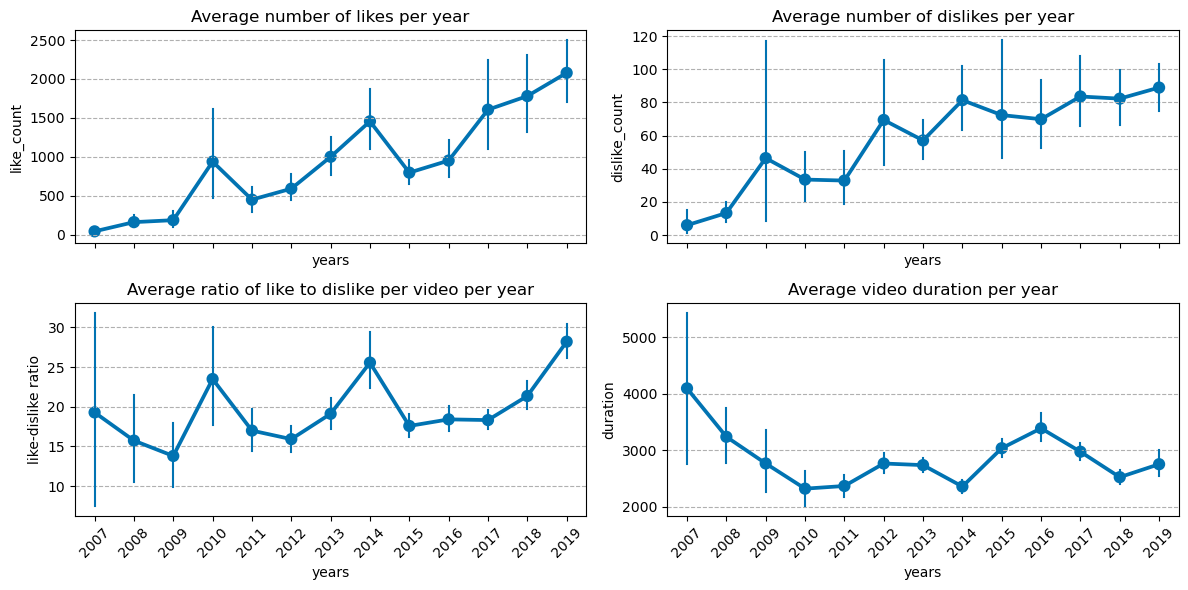

In [25]:
plot_helper(df_vd_tech)

We see from the above plot that both number of dislikes and likes have been increasing across the years. The same reasons as for the videos of less than 20 minutes can apply for this case. 

However, here we see that the length of youtube videos has been decreasing over the years: it went from more than 4000 seconds (66 minutes ~ 1 hour) in 2007 to less than 3000 seconds (50 minutes) in 2019 on average. This can be explained by the fact that youtbers noticed that longer videos bore people more and they thus went for shorter videos.

Particularly, the ratio of number of likes compared to dislikes has been increasing with high fluctuations/variance; one big jump in 2010 and another in 2014. For the one in 2010, this can be justified as seen before by the removal of the 10 minutes limit and so people could include more content and get more likes. For the second one, we analyse it further below.

Let's now see how the video duration is related to user engagement. We do it by plotting the moving average of likes to dislikes ratio over the duration of a video.

In [26]:
print("The average video duration of a video uploaded in 2013 is {0:.0f} seconds, and in 2014 it's {1:.0f}s and in 2015 it's {2:.0f}s".format(df_vd_tech_ratio[df_vd_tech_ratio['upload_year']==2013].duration.mean(), df_vd_tech_ratio[df_vd_tech_ratio['upload_year']==2014].duration.mean(),df_vd_tech_ratio[df_vd_tech_ratio['upload_year']==2015].duration.mean()))

The average video duration of a video uploaded in 2013 is 2737 seconds, and in 2014 it's 2359s and in 2015 it's 3036s


In [27]:
#compute ttest between duration means of videos uploaded in 2013 and 2014  
stats.ttest_ind(df_vd_tech_ratio[df_vd_tech_ratio['upload_year']==2013].duration, df_vd_tech_ratio[df_vd_tech_ratio['upload_year']==2014].duration)

TtestResult(statistic=4.1494218124798365, pvalue=3.538148456091029e-05, df=1372.0)

In [28]:
#compute ttest between duration means of videos uploaded in 2014 and 2015  
stats.ttest_ind(df_vd_tech_ratio[df_vd_tech_ratio['upload_year']==2014].duration, df_vd_tech_ratio[df_vd_tech_ratio['upload_year']==2015].duration)

TtestResult(statistic=-5.836749209073462, pvalue=6.597159443315029e-09, df=1408.0)

We see that there's is a statistcally significant difference between the duration average of a video from 2013, 2014 and 2015. 2014 had the lowest average duration and the highest like-dislike ratio of the 3 years, thus hinting towards the idea that people prefer shorter videos over longer ones and providing an explanaiton to why we observe the peak in 2014. 

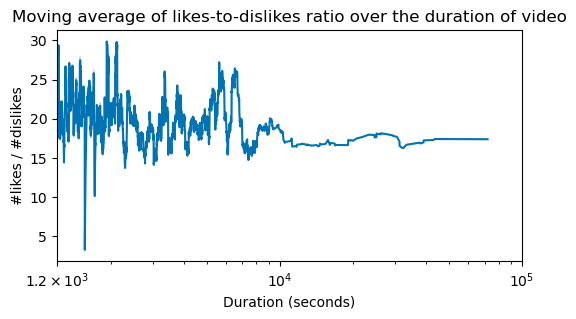

In [29]:
plot_moving_avg(df_vd_tech_ratio, 100, 0)

To analyse this plot well we also plot the below 4 plots.

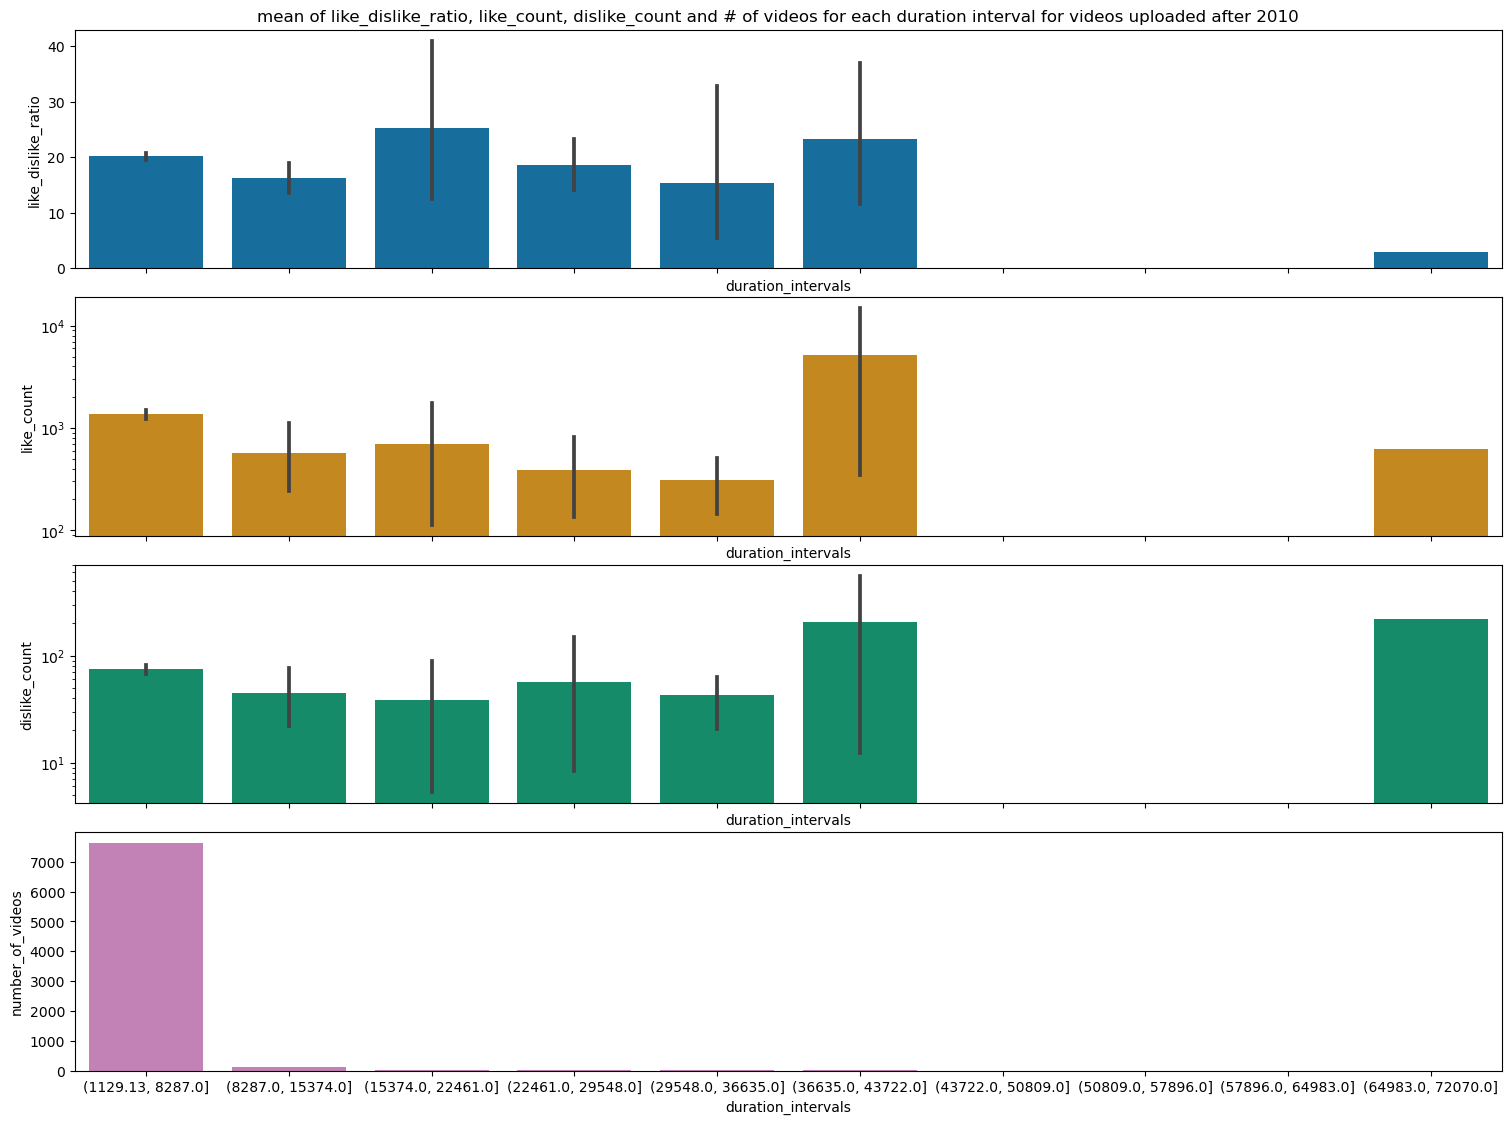

In [30]:
plot_statistics_across_duration_intervals(df_vd_tech_ratio, 2004)

We see from the moving average plot, that for videos of duration between 1200 seconds (=20 minutes) and 10000 seconds (~2.7 hours), the moving average of like to dislike ratio is fluctuating between 5 and 30 which is reasonable as there are many videos in that range (from long vlogs, to documentaries to football matches to movies...), as is shown by the 4th plot showing the number of videos per duration interval, and their quality differs. The interesting thing to notice here is that the moving average stagnates at 15 after the 2.7 hours mark, but we nevertheless see that the mean/average (not moving) is lower for long videos and this can be explained by the fact that the moving average is biased by previous values (which were high) as the window size is set to 100. The low like to dislike ratio for longer videos is indeed expected as first there aren't many videos of that type and they are normally boring, redundant/repetitive and thus get a low ratio. 

We also note that the best range for duration (in this case, taking the following 2 criteria into consideration: highest like-dislike ratio and probabitlity/feasabiltiy to provide a video of that length) is (1129, 8287] ~ (20 minutes, 2.3 hours] with a ratio of ~20. It's important to note that this isn't a hard rule, other ranges can also be successful depending on many other levers (video quality, topic discussed, upload frequency...).

## Conclusion

From our conducted analysis on videos' lengths, we finally come up with interesting insights to youtubers who want to move in the correct direction towards success and would like to know at what length should they cap their video. The best range is between 16 min and 2.7 hours and the main takeway here is that we certainly want to avoid having really short videos in order to provide meaningful content to viewers and also avoid having really long videos so that we avoid boring them!